In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sys.path.insert(0, '../src')
from features import *
from utils import *

In [4]:
mbit_rate = 1/125000

low_fp = '../data/240p/' 
threesixty_fp = '../data/360p/' 
med_fp = '../data/480p/'
seventwenty_fp = '../data/720p/' 
high_fp = '../data/1080p/' 

In [5]:
low_dfs = []
for file in os.listdir(low_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        low_dfs.append(pd.read_csv(low_fp+file))
    
threesixty_dfs = []
for file in os.listdir(threesixty_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        threesixty_dfs.append(pd.read_csv(threesixty_fp+file))
        
med_dfs = []
for file in os.listdir(med_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        med_dfs.append(pd.read_csv(med_fp+file))
        
seventwenty_dfs = []
for file in os.listdir(seventwenty_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        seventwenty_dfs.append(pd.read_csv(seventwenty_fp+file))
    
high_dfs = []
for file in os.listdir(high_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        high_dfs.append(pd.read_csv(high_fp+file))

In [6]:
# stdoan_low = pd.read_csv(low_fp + 'stdoan-101-action-240p-20201127.csv')
# stdoan_med = pd.read_csv(med_fp + 'stdoan-101-action-480p-20201127.csv')
# stdoan_high = pd.read_csv(high_fp + 'stdoan-101-action-1080p-20201127.csv')

In [7]:
low_ms = []
for df in low_dfs:
    low_ms.append(convert_ms_df(df,True))
    
threesixty_ms = []
for df in threesixty_dfs:
    threesixty_ms.append(convert_ms_df(df,True))
    
med_ms = []
for df in med_dfs:
    med_ms.append(convert_ms_df(df,True))
    
seventwenty_ms = []
for df in seventwenty_dfs:
    seventwenty_ms.append(convert_ms_df(df,True))
    
high_ms = []
for df in high_dfs:
    high_ms.append(convert_ms_df(df,True))

In [8]:
# low_ms = convert_ms_df(stdoan_low, True)
# med_ms = convert_ms_df(stdoan_med, True)
# high_ms = convert_ms_df(stdoan_high, True)

In [9]:
low_resamples = []
for df in low_ms:
    low_resamples.append(df.resample('500ms', on='Time').sum())
    
threesixty_resamples = []
for df in threesixty_ms:
    threesixty_resamples.append(df.resample('500ms', on='Time').sum())
    
med_resamples = []
for df in med_ms:
    med_resamples.append(df.resample('500ms', on='Time').sum())
    
seventwenty_resamples = []
for df in seventwenty_ms:
    seventwenty_resamples.append(df.resample('500ms', on='Time').sum())
    
high_resamples = []
for df in high_ms:
    high_resamples.append(df.resample('500ms', on='Time').sum())

In [10]:
# low_resample = low_ms.resample('500ms', on='Time').sum()
# med_resample = med_ms.resample('500ms', on='Time').sum()
# high_resample = high_ms.resample('500ms', on='Time').sum()


## Aggregate Features

In [11]:
## take the aggregate features of the whole chunk; download and upload
def agg_feat(df, col):
    return [np.mean(df[col]), np.std(df[col])]

## take the ratio of upload:download packets
def pkt_ratio(df):
    ms_df = convert_ms_df(df, True)
    local = np.sum(ms_df['pkt_src'] == '1') 
    server = np.sum(ms_df['pkt_src'] == '2') 
    return local / server

## take the ratio of upload:download bytes
def bytes_ratio(df):
    local = df['1->2Bytes'].sum()
    server = df['2->1Bytes'].sum()
    return local / server

## Peak Related Aggregate Features

In [12]:
## finds the peaks with mean + 2(1) std
## run the above aggregate functions on the peaks only??

def get_peak_loc(df, col, invert=False):
  'invert arg allows you to get values not considered peaks'
  df_avg = df[col].mean()
  df_std = df[col].std()
  
  threshold = df_avg + (1 * df_std)
  
  if invert:
    return np.array(df[col] < threshold)
  
  else:
    return np.array(df[col] > threshold)

## np.mean, np.var, np.std - think of more?  
def peak_time_diff(df, col):
  '''
  mess around with the different inputs for function. 
  variance seems to inflate the difference betweent the two the most with litte
  to no data manipulation. however, currently trying things like
  squaring the data before taking the aggregate function to exaggerate
  differences (moderate success??)
  '''
  peaks = df[get_peak_loc(df, col)]
  peaks['Time'] = peaks['Time'] - peaks['Time'].min()
  time_diff = np.diff(peaks['Time'] ** 2)
  return [np.mean(time_diff), np.std(time_diff)]

In [13]:
from scipy.signal import find_peaks

def peak_times(df,col,thresh):
    x = df[col]
    peaks, _ = find_peaks(x, height=thresh)
    if list(peaks) == []:
        return [-1]
    times = df.iloc[peaks]['Time'].values
    time_between_peaks = [times[i]-times[i-1]for i in range(1,len(times))]
    #print(time_between_peaks)
    #time_between_peaks[0]=0
    if time_between_peaks == []:
        return -1
    return time_between_peaks

def num_peaks(df,col,thresh):
    x = df[col]
    peaks, _ = find_peaks(x, height=thresh)
    return len(peaks)

## Spectral Features

In [14]:
def spectral_features(df, col):

    """
    welch implemention of spectral features
    resample the data before inputting (might change prereq depending on
    resource allocation)
    """

    f, Pxx_den = sp.signal.welch(df[col], fs=2)
    Pxx_den = np.sqrt(Pxx_den)

    peaks = sp.signal.find_peaks(Pxx_den)[0]
    prominences = sp.signal.peak_prominences(Pxx_den, peaks)[0]

    idx_max = prominences.argmax()
    loc_max = peaks[idx_max]

    return [f[loc_max], Pxx_den[loc_max], prominences[idx_max]]

## Chunking & Feature creation

In [15]:
## wip; need to decide chunk size eventually
## should we also make this chunking feature be our feature creation?

def chunk_data(df, interval=60):

    """
    takes in a filepath to the data you want to chunk and feature engineer
    chunks our data into a specified time interval
    each chunk is then turned into an observation to be fed into our classifier
    """

    df_list = []
    
    df['Time'] = df['Time'] - df['Time'].min()
    
    total_chunks = np.floor(df['Time'].max() / interval).astype(int)

    for chunk in np.arange(total_chunks):
      
        start = chunk * interval
        end = (chunk+1) * interval

        temp_df = (df[(df['Time'] >= start) & (df['Time'] < end)])
        
        df_list.append(temp_df)
        
    return df_list

In [16]:
def create_features(dfs, interval=60):

  features = [
    'dwl_peak_freq',
    'dwl_peak_prom',
    'dwl_max_psd',
    'dwl_bytes_avg',
    'dwl_bytes_std',
    'dwl_peak_avg',
    'dwl_peak_std',
    'upl_peak_freq',
    'upl_peak_prom',
    'upl_max_psd',
    'upl_bytes_avg',
    'upl_bytes_std',
    'upl_peak_avg',
    'upl_peak_std',
    'dwl_time_peak',#'IMAN_up_time_peak',
      'dwl_num_peak'#,'IMAN_up_num_peak'
  ]  

  vals = []
  for df in dfs:
      df_chunks = chunk_data(df, interval)

      for chunk in df_chunks:

        preproc = convert_ms_df(chunk, True)
        upl_bytes = preproc[preproc['pkt_src'] == '1'].resample('500ms', on='Time').sum()
        dwl_bytes = preproc[preproc['pkt_src'] == '2'].resample('500ms', on='Time').sum()

        ## spectral features
        dwl_spectral = spectral_features(dwl_bytes, 'pkt_size')
        upl_spectral = spectral_features(upl_bytes, 'pkt_size')

        ## aggregate features
        dwl_agg = agg_feat(chunk, '2->1Bytes')
        upl_agg = agg_feat(chunk, '1->2Bytes')

        ## peak features
        dwl_peak = peak_time_diff(chunk, '2->1Bytes')
        upl_peak = peak_time_diff(chunk, '1->2Bytes')
        
        ## iman's time between peak 
        iman_dwn_time_peak = np.mean(peak_times(chunk,'2->1Bytes',1000000))
        #iman_up_time_peak = np.mean(peak_times(chunk,'1->2Bytes',50000))
        
        ## iman's num peak
        iman_dwn_num_peak = num_peaks(chunk,'2->1Bytes',1000000)
        #iman_up_num_peak = num_peaks(chunk,'1->2Bytes',50000)


        
        feat_val = np.hstack((
          dwl_spectral,
          dwl_agg,
          dwl_peak,
          upl_spectral,
          upl_agg,
          upl_peak,
            iman_dwn_time_peak,#iman_up_time_peak,
            iman_dwn_num_peak,#iman_up_num_peak
        ))

        vals.append(feat_val)
    
  return pd.DataFrame(columns=features, data=vals).fillna(0)

## Dev Playground

In [17]:
chunk_size = 120

## Extended Model (low/med/high)

### Create Features

In [18]:
%%time
low_feat = create_features(low_dfs, chunk_size)
threesixty_feat = create_features(threesixty_dfs, chunk_size)
med_feat = create_features(med_dfs, chunk_size)
seventwenty_feat = create_features(seventwenty_dfs, chunk_size)
high_feat = create_features(high_dfs, chunk_size)

CPU times: user 1min 23s, sys: 660 ms, total: 1min 24s
Wall time: 1min 24s


In [19]:
low_feat['resolution'] = 1
threesixty_feat['resolution'] = 2
med_feat['resolution'] = 2
seventwenty_feat['resolution'] = 3
high_feat['resolution'] = 3

In [20]:
training = pd.concat([low_feat, threesixty_feat, med_feat,seventwenty_feat, high_feat]).reset_index(drop=True)
#training = pd.concat([low_feat, med_feat, high_feat]).reset_index(drop=True)

In [21]:
## SELECT SUBSETS OF FEATURES

training = training[['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','dwl_max_psd','dwl_num_peak','resolution']]


#training = training[['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','upl_peak_std','resolution']]
#training = training[['dwl_bytes_avg','upl_max_psd','dwl_max_psd','upl_peak_prom','dwl_num_peak','dwl_peak_prom','resolution']]
#training = training[['dwl_max_psd','upl_max_psd','dwl_peak_prom','upl_peak_prom','dwl_num_peak','dwl_bytes_avg','upl_bytes_std','upl_bytes_avg','resolution']]


In [22]:
training

,dwl_bytes_avg,dwl_peak_prom,upl_bytes_std,dwl_bytes_std,dwl_max_psd,dwl_num_peak,resolution
0,105818.018349,3.172323e+05,16862.760631,292073.412690,3.010390e+05,2.0,1
1,56392.975904,2.116595e+05,9105.882828,181129.552286,2.023631e+05,0.0,1
2,51312.250000,2.252769e+05,10219.868095,203432.423015,2.128232e+05,1.0,1
3,39377.755319,1.933348e+05,7590.302042,151199.194042,1.817832e+05,0.0,1
4,63535.761905,1.908308e+05,9625.049335,191208.720401,1.840692e+05,0.0,1
...,...,...,...,...,...,...,...
713,233169.513514,1.295016e+06,27193.069522,569860.008211,1.287103e+06,11.0,3
714,228929.241379,1.164929e+06,24587.033458,516817.245537,1.092980e+06,8.0,3
715,203555.510204,7.298143e+05,26150.031304,546653.912209,6.369195e+05,7.0,3
716,248339.244444,9.803294e+05,27889.468266,588179.115896,9.645212e+05,11.0,3


### Train model

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score

In [24]:
X, y = training.drop(columns=['resolution']), training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4,stratify=training['resolution'])

In [25]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

### Test Set

In [26]:
## RUN ON TEST DATA

low_test = pd.read_csv('../data/test/sgs008-109-action-240p-20210202.csv')
med_test = pd.read_csv('../data/test/sgs008-109-action-480p-20210202.csv')
high_test = pd.read_csv('../data/test/sgs008-109-action-1080p-20210202.csv')
threesixty_test = pd.read_csv('../data/test/sgs008-109-action-360p-20210213.csv')
seventwenty_test = pd.read_csv('../data/test/sgs008-109-action-720p-20210213.csv')
#low_test = pd.read_csv('../data/test/sgs008-109-action-360p-20210213.csv')
#low_test = pd.read_csv('../data/test/stdoan-102-action-720p-20201206.csv')

low_test_feat = create_features([low_test], chunk_size)
threesixty_test_feat = create_features([threesixty_test], chunk_size)
med_test_feat = create_features([med_test], chunk_size)
seventwenty_test_feat = create_features([seventwenty_test], chunk_size)
high_test_feat = create_features([high_test], chunk_size)

low_test_feat['resolution'] = 1
threesixty_test_feat['resolution'] = 2
med_test_feat['resolution'] = 2
seventwenty_test_feat['resolution'] = 3
high_test_feat['resolution'] = 3

In [27]:
test = pd.concat([low_test_feat, threesixty_test_feat, med_test_feat,seventwenty_test_feat, high_test_feat])
test = test[['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','dwl_max_psd','dwl_num_peak','resolution']]


classifier.fit(X,y)
y_pred = classifier.predict(test.drop('resolution',axis=1))
(pd.crosstab(test['resolution'], y_pred, rownames=['Actual Group'], colnames=['Predicted Group']))

Predicted Group,1,2,3
Actual Group,,,
1,15,1,0
2,0,29,1
3,1,1,28


In [28]:
accuracy_score(test['resolution'], y_pred)

0.9473684210526315

In [29]:
# import pickle
# pkl_filename = "extended_model.pkl"
# with open(pkl_filename, 'wb') as f:
#     pickle.dump(classifier, f)

In [30]:
# test = create_features([pd.read_csv('../data/test/testme.csv')],chunk_size)
# classifier.predict(test)

### Validation Set

In [31]:
## FOR VALIDATION SET

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [32]:
(pd.crosstab(y_test, y_pred, rownames=['Actual Group'], colnames=['Predicted Group']))

Predicted Group,1,2,3
Actual Group,,,
1,31,7,0
2,3,67,7
3,0,6,59


In [33]:
f1_score(y_test, y_pred, average=None)

array([0.86111111, 0.85350318, 0.90076336])

In [34]:
accuracy_score(y_test, y_pred)

0.8722222222222222

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(classifier,X,y,cv=10)

array([0.86486486, 0.63888889, 0.81944444, 0.86111111, 0.68055556,
       0.88888889, 0.87323944, 0.81690141, 0.78873239, 0.90140845])

### Feature Importances

In [36]:
features = ['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','dwl_max_psd','dwl_num_peak']
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
    print(features[i],': ',importances[i])
    

dwl_peak_prom :  0.2414375525324613
dwl_max_psd :  0.22354892137793173
dwl_num_peak :  0.2154884116670213
dwl_bytes_std :  0.13171410051275204
dwl_bytes_avg :  0.10303077483219306
upl_bytes_std :  0.08478023907764068


Text(0, 0.5, 'Features')

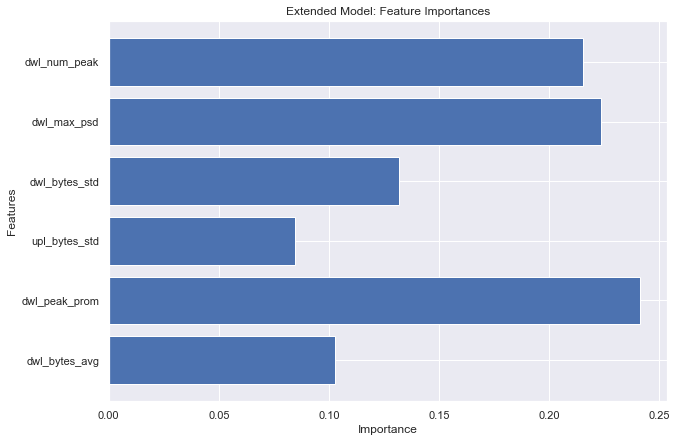

In [37]:
sns.set(rc={'figure.figsize':(10,7)})
plt.barh(features,importances)
plt.title('Extended Model: Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

In [38]:
# features = ['dwl_peak_freq','dwl_peak_prom','dwl_max_psd','dwl_bytes_avg','dwl_bytes_std','dwl_peak_avg',
#             'dwl_peak_std','upl_peak_freq','upl_peak_prom','upl_max_psd','upl_bytes_avg','upl_bytes_std',
#             'upl_peak_avg','upl_peak_std','dwl_time_peak','dwl_num_peak']
# importances = classifier.feature_importances_
# indices = np.argsort(importances)[::-1]
# for i in indices:
#     print(features[i],': ',importances[i])
    

## Basline Model (3 resolutions)

In [39]:
## BASELINE MODEL

baseline_training = pd.concat([low_feat, med_feat, high_feat]).reset_index(drop=True)
baseline_training = baseline_training[['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','upl_peak_std','resolution']]

X, y = baseline_training.drop(columns=['resolution']), baseline_training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4,stratify=baseline_training['resolution'])

baseline_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
baseline_classifier.fit(X_train, y_train)
y_pred = baseline_classifier.predict(X_test)
#(pd.crosstab(y_test, y_pred, rownames=['Actual Group'], colnames=['Predicted Group']))

In [40]:
#accuracy_score(y_test, y_pred)

In [41]:
## RUN ON TEST DATA

low_test = pd.read_csv('../data/test/sgs008-109-action-240p-20210202.csv')
med_test = pd.read_csv('../data/test/sgs008-109-action-480p-20210202.csv')
high_test = pd.read_csv('../data/test/sgs008-109-action-1080p-20210202.csv')
# threesixty_test = pd.read_csv('../data/test/sgs008-109-action-360p-20210213.csv')
# seventwenty_test = pd.read_csv('../data/test/sgs008-109-action-720p-20210213.csv')
#low_test = pd.read_csv('../data/test/sgs008-109-action-360p-20210213.csv')
#low_test = pd.read_csv('../data/test/stdoan-102-action-720p-20201206.csv')

low_test_feat = create_features([low_test], chunk_size)
#threesixty_test_feat = create_features([threesixty_test], chunk_size)
med_test_feat = create_features([med_test], chunk_size)
#seventwenty_test_feat = create_features([seventwenty_test], chunk_size)
high_test_feat = create_features([high_test], chunk_size)

low_test_feat['resolution'] = 1
#threesixty_test_feat['resolution'] = 2
med_test_feat['resolution'] = 2
#seventwenty_test_feat['resolution'] = 4
high_test_feat['resolution'] = 3

test = pd.concat([low_test_feat, med_test_feat, high_test_feat])
test = test[['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','upl_peak_std','resolution']]


baseline_classifier.fit(X,y)
y_pred = baseline_classifier.predict(test.drop('resolution',axis=1))
(pd.crosstab(test['resolution'], y_pred, rownames=['Actual Group'], colnames=['Predicted Group']))

Predicted Group,1,2,3
Actual Group,,,
1,16,0,0
2,1,14,0
3,1,1,13


In [42]:
accuracy_score(test['resolution'], y_pred)

0.9347826086956522

In [43]:
features = ['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','upl_peak_std']
importances = baseline_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
    print(features[i],': ',importances[i])

dwl_peak_prom :  0.3877441409813034
dwl_bytes_std :  0.26687555375743827
dwl_bytes_avg :  0.14488143672315623
upl_bytes_std :  0.11738473671812573
upl_peak_std :  0.08311413181997632


Text(0, 0.5, 'Features')

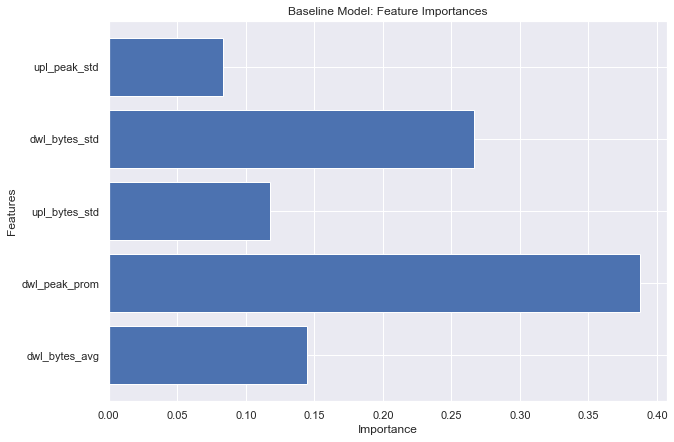

In [44]:
plt.barh(features,importances)
plt.title('Baseline Model: Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

In [45]:
# pkl_filename = "baseline_model.pkl"
# with open(pkl_filename, 'wb') as f:
#     pickle.dump(classifier, f)